In [317]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue
from Softmax import softmax
from Adam import Adam
from SimpleNN import SimpleNN

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board.reshape(1,-1), self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board.reshape(1,-1), self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask
    
    def transform_index(self, index):
        return index // 3, index % 3

In [230]:
class TicTacToeAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.discount = agent_init_info["discount"]        
        self.network = agent_init_info["network"]
        self.optimizer = agent_init_info["optimizer"]
        self.tau = agent_init_info["tau"]
        self.num_actions = agent_init_info["num_actions"]
        
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        action_values = self.network.get_action_values(state)
        probs = softmax(action_values, self.tau) 
        probs *= mask
        probs /= probs.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        self.last_state = state
        self.last_action = self.policy(self.last_state, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        action = self.policy(state, mask)
        self.network.get_action_values(state)
        delta = reward + self.discount * self.network.get_action_values(state)[action] - \
                    self.network.get_action_values(self.last_state)[self.last_action]        
        delta_mat = np.zeros((1,self.num_actions))
        delta_mat[0, self.last_action] = delta
        
        grads = self.network.get_gradients(self.last_state, delta_mat)
        self.optimizer.update_weights(self.network.get_weights(), grads)
        
        self.last_state = state
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        delta = reward - self.network.get_action_values(self.last_state)[self.last_action]        
        delta_mat = np.zeros((1,self.num_actions))
        delta_mat[0, self.last_action] = delta
        
        grads = self.network.get_gradients(self.last_state, delta_mat)
        self.optimizer.update_weights(self.network.get_weights(), grads)
        
    def agent_message(self, message):
        pass

# Train

In [379]:
# define the function approximator - a Feed-Forward NN 
layers1 = [9, 36, 18, 9]
layers2 = [9, 36, 18, 9]
nn1 = SimpleNN({"layer_sizes": layers1, "seed": 11})  # relu activations
nn2 = SimpleNN({"layer_sizes": layers2, "seed": 2})  # relu activations

In [380]:
# define the optimizer - ADAM (Momentum + RMSProp)
optimizer_info = { "step_size": .1,
                  "beta_m": 0.99,
                  "beta_v": 0.999,
                  "epsilon": 0.0001 }
optimizer1 = Adam(layers1, optimizer_info)
optimizer2 = Adam(layers2, optimizer_info)

In [381]:
# debug
nn1.get_weights()[0]["W"][0][:4]

array([ 0.337463  , -0.05518237, -0.09347073, -0.51181481])

In [382]:
nn2.get_weights()[0]["W"][0][:4]

array([-0.06329854, -0.00854599, -0.32445245,  0.2491297 ])

In [383]:
runs = 30000

In [384]:
def experiment(runs, nns, optimizers):
    rlglue = RLGlue(TicTacToeEvnironment, TicTacToeAgent, TicTacToeAgent)
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    agent1_info = {"discount": 1, "network": nns[0], "optimizer": optimizers[0], "tau": 1, "num_actions": 9, "seed": 12}
    agent2_info = {"discount": 1, "network": nns[1], "optimizer": optimizers[1], "tau": 1, "num_actions": 9, "seed": 17}
    env_info = {}
    rlglue.rl_init(agent1_info, agent2_info, env_info)

    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [385]:
rlg, rew, starts, states = experiment(runs, [nn1, nn2], [optimizer1, optimizer2])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:16<00:00, 393.96it/s]


# Test

In [386]:
starts[-1], states[-1]

(array([1.]), array([ 1.,  1.,  1.,  1., -1.,  0., -1.,  0., -1.]))

In [387]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(15908, 12316)

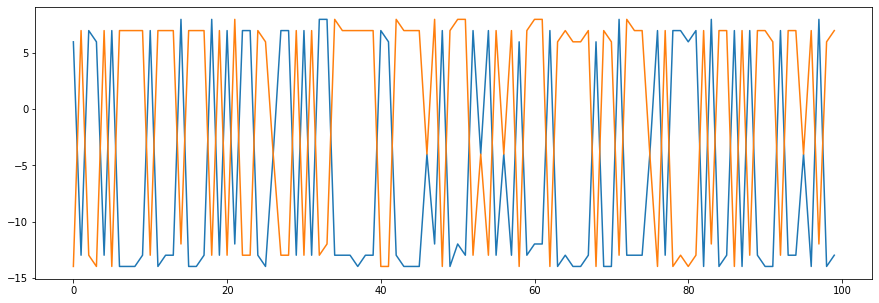

In [388]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

In [389]:
env = TicTacToeEvnironment()
env.env_init()
ret = env.env_start()

In [391]:
ai = rlg.agents[1]["agent"]
ai.network.get_action_values(ret[0])

array([-0.95592556, -3.07099858, -1.72450445, -1.60608913, -1.94085039,
       -4.71079213, -2.22630735, -2.15931284, -2.75558167])

In [369]:
ai.agent_start(ret[0], ret[1])

3

In [263]:
ret = env.env_step(-1, 4)

In [264]:
# Human (aka - me) will play 0, top-left
ret = env.env_step(1, 0)

In [268]:
action = ai.agent_step(-1, ret[1], ret[3])
action

3

In [269]:
ret = env.env_step(-1, action)

In [270]:
# I choose 1, top-middle
ret = env.env_step(1, 1)

In [271]:
action = ai.agent_step(-1, ret[1], ret[3])
action

5

In [272]:
ret = env.env_step(-1, action)

In [273]:
ret  # AI wins :-) 

(10,
 array([[ 1.,  1.,  0., -1., -1., -1.,  0.,  0.,  0.]]),
 True,
 array([0., 0., 1., 0., 0., 0., 1., 1., 1.]))

let's try again

In [298]:
ai = rlg.agents[-1]["agent"]

In [299]:
state, mask = env.env_start()

In [300]:
ai.network.get_action_values(state)

array([-4.47968785, -6.5683146 , -3.30616794,  0.10791578,  0.51350736,
        0.38507136, -1.97239166, -5.88189067, -4.42064227])

In [301]:
action = ai.agent_start(state, mask)
action

4

In [303]:
reward, state, ter, mask = env.env_step(-1, action)

In [304]:
reward, state, ter, mask = env.env_step(1, 0)

In [305]:
action = ai.agent_start(state, mask)
action

3

In [307]:
reward, state, ter, mask = env.env_step(-1, action)

In [309]:
reward, state, ter, mask = env.env_step(1, 5)

In [310]:
action = ai.agent_start(state, mask)
action

6

In [312]:
reward, state, ter, mask = env.env_step(-1, action)

In [313]:
state

array([[ 1.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.]])

In [314]:
# let's say I somehow missed
reward, state, ter, mask = env.env_step(1, 8)

In [315]:
action = ai.agent_start(state, mask)
action

2

In [316]:
# AI wins again
env.env_step(-1, action)

(10,
 array([[ 1.,  0., -1., -1., -1.,  1., -1.,  0.,  1.]]),
 True,
 array([0., 1., 0., 0., 0., 0., 0., 1., 0.]))

In [320]:
# lets save this agent
fw = open('agent-1-network-weights', 'wb')
pickle.dump(ai.network.weights, fw)
fw.close()